In [1]:
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO,TraceEnum_ELBO,config_enumerate
import torch.distributions.constraints as constraints

pyro.enable_validation(True)

In [2]:
D = 4          #document
N = [15,8,9,11]   #words
K = 5          #topics
V = 15        #vocabulary size

theta = dist.Dirichlet(torch.zeros([D, K])+0.1).sample()
phi = dist.Dirichlet(torch.zeros([K, V])+0.05).sample()

z = [torch.zeros(n, dtype=torch.long) for n in N]
data = [torch.zeros(n) for n in N]
for d in range(D):
    for n in range(N[d]):
        z[d][n] = dist.Categorical(theta[d, :]).sample()
        data[d][n] = dist.Categorical(phi[z[d][n], :]).sample()

In [3]:
phi[1]

tensor([ 1.2295e-02,  4.8137e-07,  1.1921e-07,  1.1921e-07,  1.1921e-07,
         2.8339e-05,  2.5572e-05,  1.1921e-07,  1.4379e-04,  1.0899e-03,
         3.4792e-07,  9.8628e-01,  1.8542e-05,  1.1432e-04,  1.1921e-07])

In [4]:
print(pyro.sample("w_%d"%1, dist.Categorical(phi[1])))

tensor(11)


In [5]:
print(data[1])

tensor([ 12.,   2.,   2.,   2.,  12.,  12.,  10.,  12.])


In [6]:
@pyro.poutine.broadcast
def model(data):
    phi = pyro.sample("phi",dist.Dirichlet(torch.ones([K, V])).independent(1))
  
    for d in pyro.irange("documents", D):
        theta_d = pyro.sample("theta_%d"%d, dist.Dirichlet(torch.ones([K])))
    
        with pyro.iarange("words_%d"%d, N[d]):
            z = pyro.sample("z_%d"%d, dist.Categorical(theta_d))
            pyro.sample("w_%d"%d, dist.Categorical(phi[z]), obs=data[d])
        
@pyro.poutine.broadcast
def guide(data):
    beta_q = pyro.param("beta_q", torch.ones([K, V]),constraint=constraints.positive)
    pyro.sample("phi",dist.Dirichlet(beta_q).independent(1))
  
    for d in pyro.irange("documents", D):
        alpha_q = pyro.param("alpha_q_%d"%d, torch.ones([K]),constraint=constraints.positive)
        pyro.sample("theta_%d"%d, dist.Dirichlet(alpha_q))
    
        with pyro.iarange("words_%d"%d, N[d]):
            q_i = pyro.param("q_%d"%d, torch.randn([N[d], K]).exp(),
                             constraint=constraints.simplex)
            pyro.sample("z_%d"%d, dist.Categorical(q_i))

In [7]:
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

pyro.clear_param_store()
svi = SVI(model, config_enumerate(guide, 'parallel'), optimizer, loss=TraceEnum_ELBO(max_iarange_nesting=2))



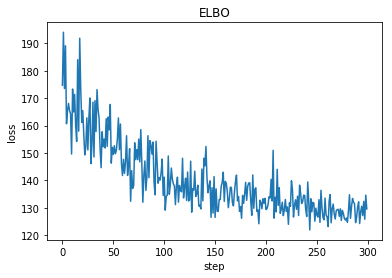

In [8]:
losses = []
for t in range(300):
    losses.append(svi.step(data))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [14]:
type(losses[0])

float

In [9]:
pyro.param('q_3')

tensor([[ 0.1271,  0.1717,  0.2059,  0.2488,  0.2465],
        [ 0.1247,  0.2284,  0.1924,  0.2634,  0.1910],
        [ 0.1246,  0.1702,  0.2290,  0.2444,  0.2319],
        [ 0.1282,  0.2082,  0.2130,  0.1951,  0.2554],
        [ 0.1386,  0.2015,  0.1905,  0.2301,  0.2393],
        [ 0.2026,  0.2201,  0.1341,  0.2817,  0.1615],
        [ 0.1331,  0.2247,  0.1919,  0.2191,  0.2311],
        [ 0.1248,  0.2176,  0.2078,  0.2268,  0.2229],
        [ 0.1233,  0.2297,  0.2044,  0.2398,  0.2028],
        [ 0.2023,  0.1708,  0.1335,  0.3048,  0.1886],
        [ 0.1270,  0.2012,  0.2341,  0.2022,  0.2355]])

In [21]:
aa = np.zeros([2,5])
aa[0,:] = pyro.param('q_3')[0].detach().numpy()
print(aa)

[[0.12712824 0.17167149 0.20592479 0.24880783 0.24646768]
 [0.         0.         0.         0.         0.        ]]


In [10]:
z[3]

tensor([ 3,  1,  3,  1,  1,  3,  1,  1,  1,  3,  1])

In [11]:
dist.Dirichlet(pyro.param('beta_q')).sample()[1]

tensor([ 0.1718,  0.0291,  0.1095,  0.0263,  0.0123,  0.0766,  0.0110,
         0.0452,  0.1632,  0.0163,  0.0381,  0.1182,  0.0988,  0.0388,
         0.0450])

In [12]:
phi[1].max(0)

(tensor(0.9863), tensor(11))